# Audio Classification - Time Frequency Analysis

In [1]:
import os
import sys
import types
# import ibm_boto3

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from io import BytesIO
from zipfile import ZipFile
# from botocore.client import Config

from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import accuracy_score

try:
    import soundfile as sf
    import librosa
except:   
    # libsndfile is not in the default conda repo, so we have to add conda-forge
    !conda config --add channels conda-forge
    !conda install -y libsndfile
    !pip install soundfile
    !pip install librosa

    import soundfile as sf
    import librosa

try:
    import pywt
except:
    !pip install pywt
    import pywt    
    

    
%matplotlib inline

/opt/rh/python27/root/usr/lib/python2.7/site-packages/librosa/__init__.py:40: DeprecationWarning: You are using librosa with Python 2. Please note that librosa 0.7 will be the last version to support Python 2, after which it will require Python 3 or later.
  DeprecationWarning)


In [2]:
zip_file = ZipFile('audio.zip')

In [3]:
ZipFile.namelist(zip_file)

['children_playing/',
 'dog_bark/',
 'children_playing/97317-2-0-5.wav',
 'children_playing/97317-2-0-36.wav',
 'children_playing/97317-2-0-34.wav',
 'children_playing/97317-2-0-28.wav',
 'children_playing/97317-2-0-25.wav',
 'children_playing/97317-2-0-23.wav',
 'children_playing/97317-2-0-22.wav',
 'children_playing/15564-2-0-2.wav',
 'children_playing/15564-2-0-1.wav',
 'children_playing/15564-2-0-0.wav',
 'children_playing/143651-2-0-63.wav',
 'children_playing/143651-2-0-59.wav',
 'children_playing/143651-2-0-55.wav',
 'children_playing/143651-2-0-39.wav',
 'children_playing/143651-2-0-22.wav',
 'children_playing/143651-2-0-20.wav',
 'children_playing/143651-2-0-16.wav',
 'children_playing/143651-2-0-0.wav',
 'children_playing/138031-2-0-7.wav',
 'children_playing/138031-2-0-47.wav',
 'children_playing/138031-2-0-45.wav',
 'children_playing/138031-2-0-28.wav',
 'children_playing/138031-2-0-23.wav',
 'children_playing/138031-2-0-22.wav',
 'children_playing/138031-2-0-2.wav',
 'chil

In [4]:
audio_data = []
labels = []
sampling_rate = []
file_names = []

for file_name in ZipFile.namelist(zip_file):
    # Skip directories
    if not os.path.basename(file_name):
        continue
    
    audio_file = None
    if file_name.startswith("children_playing/"):
        labels.append(0)
        audio_file = zip_file.open(file_name)
    elif file_name.startswith("dog_bark/"):
        labels.append(1)
        audio_file = zip_file.open(file_name)
    else:
        print("Unknown file class. Skipping.")

    if audio_file is not None:
        file_names.append(file_name)
        tmp = BytesIO(audio_file.read())
        data, samplerate = sf.read(tmp)
        audio_data.append(data)
        sampling_rate.append(samplerate)   

In [5]:
for index in range(len(audio_data)):
    
    if (sampling_rate[index] == 48000):
        audio_data[index] = librosa.resample(audio_data[index], 48000, 44100)
        sampling_rate[index] = 44100


In [6]:
def to_mono(data):
    if data.ndim > 1:
        data = np.mean(data, axis=1)
    return data

for index in range(len(audio_data)):
    audio_data[index] = to_mono(audio_data[index])

## Children Playing

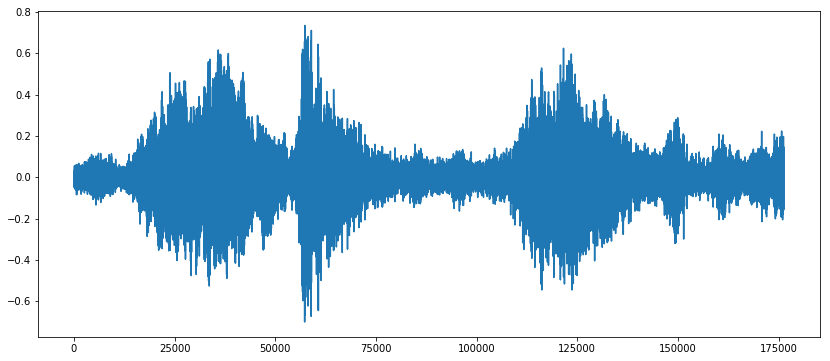

In [15]:
fig = plt.figure(figsize=(14,6))
plt.plot(audio_data[1])

## Dog Barking

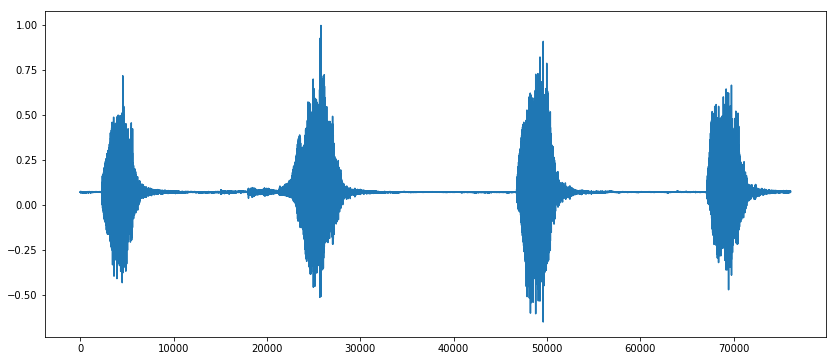

In [16]:
fig = plt.figure(figsize=(14,6))
plt.plot(audio_data[51])

In [98]:
scales = np.arange(1, 101)
coeff1, freqs1 = pywt.cwt(audio_data[1][:70000], scales, 'morl')
coeff2, freqs2 = pywt.cwt(audio_data[51][:70000], scales, 'morl')

## Scaleograms

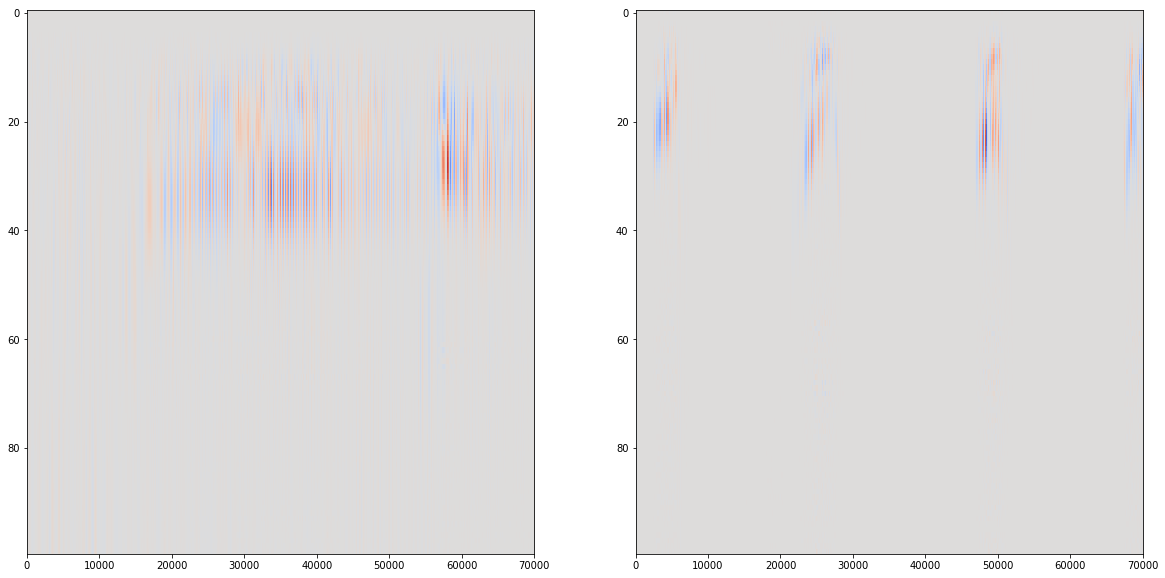

In [99]:
plt.figure(1, figsize=(20,10))
plt.subplot(121)
plt.imshow(coeff1, cmap='coolwarm', aspect='auto')  
plt.subplot(122)
plt.imshow(coeff2, cmap='coolwarm', aspect='auto')  

plt.show() 

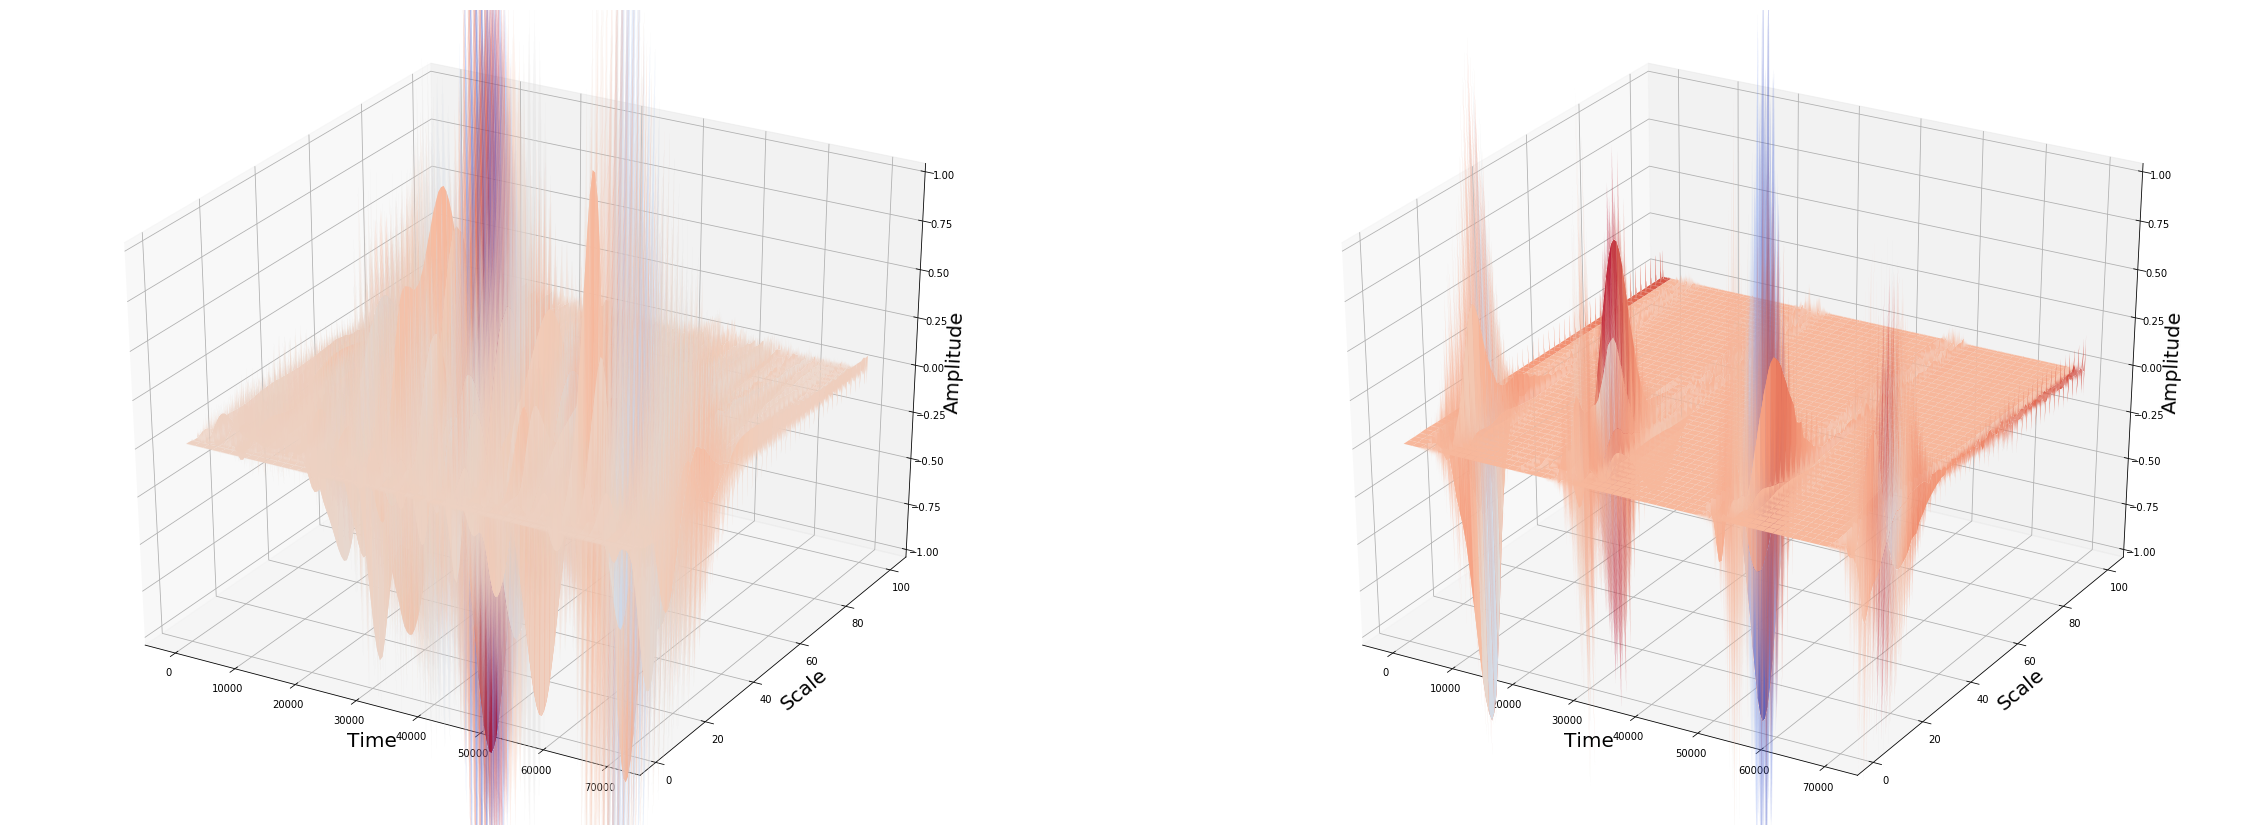

In [100]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

fig = plt.figure(figsize=(40,15))

ax1 = fig.add_subplot(1, 2, 1, projection='3d')

Y = np.arange(1, 101, 1)
X = np.arange(1, 70001, 1)

X, Y = np.meshgrid(X, Y)

ax1.plot_surface(X, Y, coeff1, cmap=cm.coolwarm, linewidth=0, antialiased=True)

ax1.set_xlabel("Time", fontsize=20)
ax1.set_ylabel("Scale", fontsize=20)
ax1.set_zlabel("Amplitude", fontsize=20)
ax1.set_zlim3d(-1,1)

ax2 = fig.add_subplot(1, 2, 2, projection='3d')

ax2.plot_surface(X, Y, coeff2, cmap=cm.coolwarm, linewidth=0, antialiased=True)


ax2.set_xlabel("Time", fontsize=20)
ax2.set_ylabel("Scale", fontsize=20)
ax2.set_zlabel("Amplitude", fontsize=20)
ax2.set_zlim3d(-1,1)

plt.show()

In [214]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1)

features = np.empty((0,100))

for ind in range(len(audio_data)):
    coeff, freqs = pywt.cwt(audio_data[ind][:20000], scales, 'morl')    
    features = np.vstack([features, pca.fit_transform(coeff).flatten()])


In [224]:
from pyspark.mllib.util import MLUtils
convertedVecDF = MLUtils.convertVectorColumnsToML(features)

TypeError: Input dataset must be a DataFrame but got <type 'numpy.ndarray'>.

In [130]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.15, random_state=42)

In [131]:
clf = svm.SVC()
clf.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [132]:
y_pred = clf.predict(X_test)
print("Accuracy : %.2f%%" % (accuracy_score(y_test, y_pred) * 100))

Accuracy : 60.00%


In [195]:
from pyspark.ml.feature import PCA

In [213]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1)

features = np.empty((0,100))

for ind in range(len(audio_data)):
    coeff, freqs = pywt.cwt(audio_data[ind][:20000], scales, 'morl')    
    features = np.vstack([features, pca.fit_transform(coeff).flatten()])

(100, 20000)
(200, 20000)


In [ ]:
import pandas as pd

In [ ]:
pd.creat